# Gaussian Process Regression with PyMC

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import pytensor.tensor as pt
from scipy.special import expit as logistic

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In the following, we generate data points based on a sin function. We assume that we do not know the function, all we have is a set of data points (dots). Then we use a Gaussian process to approximate the function that generated those data points.

Text(0, 0.5, 'f(x)')

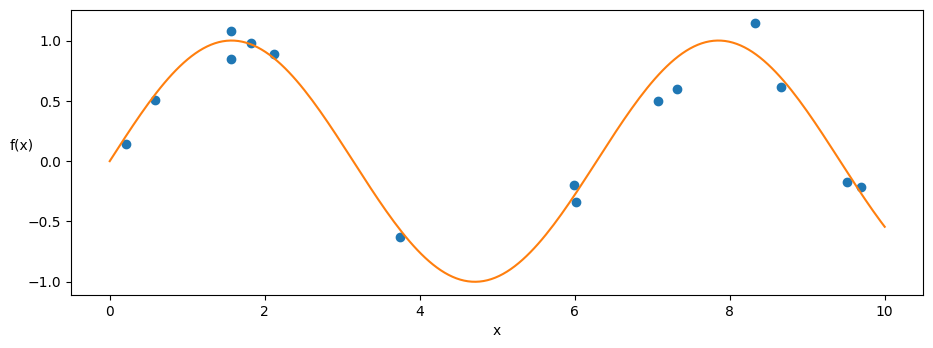

In [2]:
np.random.seed(42)
x = np.random.uniform(0, 10, size=15)
y = np.random.normal(np.sin(x), 0.1)
df = pd.DataFrame({'x': x, 'y': y})

_, ax = plt.subplots(figsize=(11, 3.7))
ax.plot(x, y, 'o')
true_x = np.linspace(0, 10, 200)
ax.plot(true_x, np.sin(true_x), 'C1')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation=0)

GPs are implemented in PyMC as a series of Python classes that deviate a little bit from what we have seen in previous models:

In [3]:
# A one-dimensional column vector of inputs.
X = x[:, None]

with pm.Model() as model_reg:
    # hyperprior for lengthscale kernel parameter
    ℓ = pm.InverseGamma("ℓ", 7, 17)
    
    # instantiate a covariance function
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    # instantiate a GP prior
    gp = pm.gp.Marginal(cov_func=cov)

    σ = pm.HalfNormal('σ', 25)

    y_pred = gp.marginal_likelihood('y_pred', X=X, y=y, sigma=σ)
    idata_reg = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ℓ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Notice that instead of a Gaussian likelihood, we have used the `gp.marginal_likelihood` method. This method takes advantage of the fact that the posterior has a closed form. Once we have computed the posterior, we get the predictions of the mean fitted function by computing the conditional distribution evaluated over new input locations using `gp.conditional`.

In [4]:
X_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 100)[:,None]

with model_reg:
    f_pred = gp.conditional('f_pred', X_new)

As a result, we get a new PyMC random variable `f_pred` which we can use to get samples from the posterior predictive distribution.

In [5]:
with model_reg:
    idata_reg_subset = idata_reg.sel(draw=slice(0, None, 100))
    pred_samples = pm.sample_posterior_predictive(idata_reg_subset,
                                                  var_names=["f_pred"],
                                                  random_seed=123)

f_pred = (pred_samples.
          posterior_predictive.stack(samples=("chain", "draw"))['f_pred'].
          values)

Sampling: [f_pred]


Output()

Now, we can plot the fitted functions over the original data to visually inspect how well they fit the data and the associated uncertainty in our predictions. As we did with linear models, we are going to show different ways to plot the same results. The following figure shows lines from the fitted function.

Text(0.5, 0, 'X')

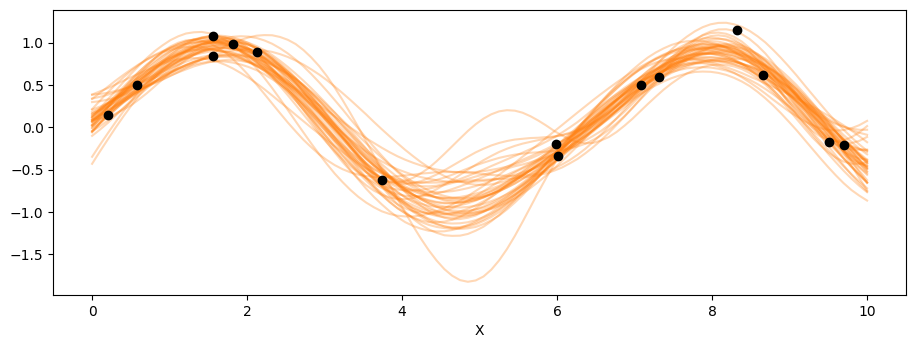

In [7]:
_, ax = plt.subplots(figsize=(11, 3.7))
ax.plot(X_new, f_pred, 'C1-', alpha=0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X')

Alternatively, we can use  the auxilliary function `pm.gp.util.plot\_gp\_dist' to get some nice plots as shown in the following figure:

Text(0, 0.5, 'f(x)')

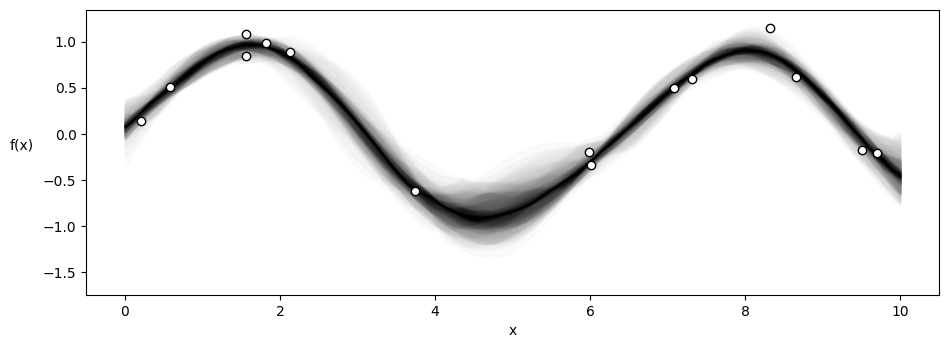

In [10]:
_, ax = plt.subplots(figsize=(11, 3.7))

pm.gp.util.plot_gp_dist(ax, f_pred.T, X_new, palette='gray_r', plot_samples=False);

ax.plot(X, y, 'wo', mec='k')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation=0, labelpad=15)

In this plot, each band represents a different percentile, ranging from percentile 99 (lighter gray) to percentile 51 (darker gray).

Yet another alternative is to compute the mean vector and standard deviation of the conditional distribution evaluated at a given point in the parameter space. In the following figure, we use the mean (over the samples in the trace) for $\mathcal{l}$ and $\mathcal{\epsilon}$. We can compute the mean and variance using the `gp.predict` method.

Text(0.5, 0, 'X')

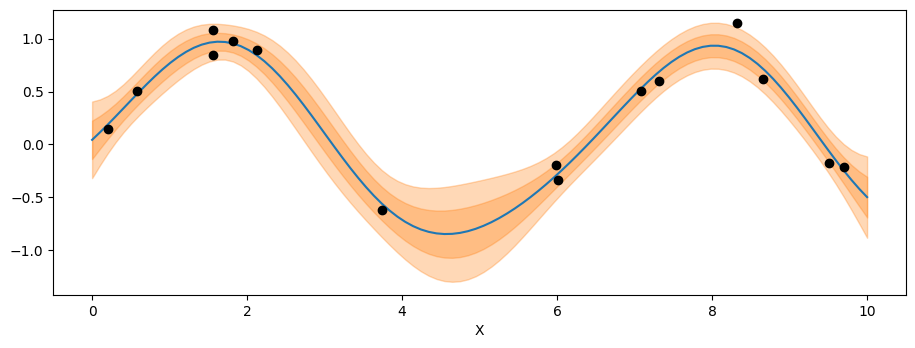

In [9]:
# plot the results
_, ax = plt.subplots(figsize=(11, 3.7))

# predict
point = {'ℓ': idata_reg.posterior['ℓ'].mean(), 'σ': idata_reg.posterior['σ'].mean()}
mu, var = gp.predict(X_new, point=point, diag=True,  model=model_reg)
sd = var**0.5

# plot mean and 1σ and 2σ intervals
ax.plot(X_new, mu, 'C0')
ax.fill_between(X_new.flatten(),
                 mu - sd, mu + sd,
                 color="C1",
                 alpha=0.3)

ax.fill_between(X_new.flatten(),
                 mu - 2*sd, mu + 2*sd,
                 color="C1",
                 alpha=0.3)

ax.plot(X, y, 'ko')
ax.set_xlabel('X')

## Setting Priors for the length scale

For length-scale parameters, priors avoiding zero usually work better. As we already saw, $\mathcal{l}$ controls the smoothness of the function, thus a value of 0 for $\mathcal{l}$ implies a non-smooth function. For values of $\mathcal{l}$ that are larger than $0$ but still below the minimum spacing of the covariates, the likelihood has not way to distinguish between different length scales, so all of them are equally good. As a result, we will have a GP that will tend to overfit and exactly interpolate between the input data. Additionally, the MCMC sampler will have a harder time, and we could get longer sampling times or simple unreliable samples. Something similar happens for values beyond the range of the data: this implies a flat function and your likelihood function has no way of distinguishing between different values of the parameter. Thus even if you have no idea how smooth or wiggly your function is, you can still set a prior that avoids very low and very high values of $\mathcal{l}$. For instance, to get the prior `pm.InverseGamma("ℓ", 7, 17)` we ask PreliZ for the maximum entropy prior that has 0.95 of the mass between 1 and 5:

In the following, we will use the function `get_ig_params` to obtain weakly informative priors from the scale of the covariates.

In [11]:
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.95, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [12]:
# A one-dimensional column vector of inputs.
X = x[:, None]

with pm.Model() as model_reg:
    # hyperprior for lengthscale kernel parameter
    ℓ = pm.InverseGamma("ℓ", **get_ig_params(x, l_b=1))
    
    # instanciate a covariance function
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    # instanciate a GP prior
    gp = pm.gp.Marginal(cov_func=cov)

    σ = pm.HalfNormal('σ', 25)

    y_pred = gp.marginal_likelihood('y_pred', X=X, y=y, sigma=σ)
    idata_reg = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ℓ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


# Hilbert Space GPs with Bambi

Gaussian processes can be slow. The main reason is that their computation requires us to invert a matrix whose size grows with the number of observations. This operation is computationally costly and does not scale very nicely. For that reason, a large portion of the research around GPs has been to find approximations to compute them faster and allow scaling them to large data. 

__Hilbert Space Gaussian Process (HSGP)__ is one of these approximations. Conceptually, we can think of it as a basis function expansion similar, in spirit, to how splines are constructed. The consequence of this approximation is that it turns the matrix inversion into just matrix multiplication, a much faster operation. 

We can only huse HSGP for low dimensions (1 to maybe 3 or 4), and only for some kernels like the exponential quadratic or Matern. The reason is that for the HSGP approximation  to work, the kernel has to be written in a special form known as power spectral density, and not all kernels can be written in this form. 

To fit the previous model with Bambi, we need to write the following:

In [23]:
model_hsb = bmb.Model("y ~ hsgp(x, m=15, c=1.5)",df)
idata_hsb = model_hsb.fit(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, hsgp(x, m=15, c=1.5)_sigma, hsgp(x, m=15, c=1.5)_ell, hsgp(x, m=15, c=1.5)_weights_raw]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
There were 267 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


- `m` is the number of basic functions we use to approximate the GP. The larger the value of $m$, the better the approximation will be and the more costly the computation.

- `c` is a boundary factor. For a fixed and sufficiently large value of `m`, `c` affects the approximation of the mean mainly near the boundaries. It should not be smaller than 1.2, and usually 1.5 os a good choice. Changing this parameter does not affect the speed of the computations. 

Since this direct approach won't work, we will provide priors to Bambi, as we did with PyMC. This will result in a much faster sampling and more reliable samples.

We need to pass a dictionary to the `priors` argument of `bmp.Model`. But we must be aware that HSGP  terms do not receive priors. Instead, we need to define priors for $\mathcal{l}$ (called `ell` in Bambi) and $\eta$ (called `sigma` in Bambi) and pass those priors to the HSGP terms. One more thing: as in the previous model, we did not use $\eta$ but since Bambi is expecting it, we use a dirty trick to define a prior that is essentially 1.

In [26]:
# Define priors

prior_gp = {
    "sigma": bmb.Prior("Gamma", mu=1, sigma=0.01),
    "ell": bmb.Prior("InverseGamma", **get_ig_params(X)) 
}

priors = {
    "hsgp(x, m=10, c=1.5)": prior_gp,
    "alpha": bmb.Prior("HalfNormal", sigma=1)
}

Now, we can fit the Bambi model.

In [27]:

model_hsb = bmb.Model("y ~ 0 + hsgp(x, m=10, c=1.5)",df, priors=priors )
idata_hsb = model_hsb.fit(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, hsgp(x, m=10, c=1.5)_sigma, hsgp(x, m=10, c=1.5)_ell, hsgp(x, m=10, c=1.5)_weights_raw]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.


In [19]:
az.summary(idata_hsb, var_names=["hsgp(x, m=10, c=1.5)_ell"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"hsgp(x, m=10, c=1.5)_ell",1.404,0.293,0.872,1.966,0.012,0.008,629.0,486.0,1.0


/opt/conda/lib/python3.10/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: x


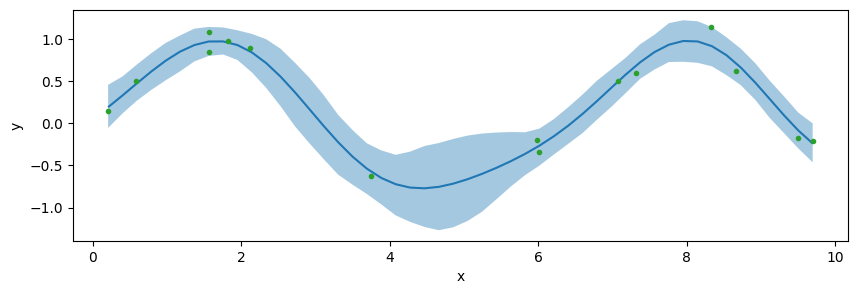

In [28]:
_, ax = bmb.interpret.plot_predictions(model_hsb, idata_hsb, ["x"],
                                       fig_kwargs={"figsize": (10, 3)})
ax[0].plot(df["x"], df["y"], "C2.")

By combining the flexibility of PyMC and Bambi with the scalability offered by HSGPs, researchers and practioners can more effectively tackle complex modeling tasks, paving the way for the application of Gaussian processes on increasingly large and intricate datasets.